In [1]:
import numpy as np
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
N = 200

X = np.random.uniform(low=-50, high=50, size=(N, 2))
T = X@np.array([[3.2],[-5]]) + np.random.normal(size=(N, 1), scale=5.5)
T.shape, X.shape

((200, 1), (200, 2))

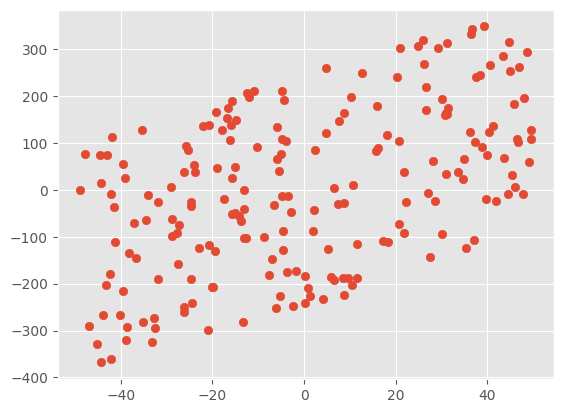

In [3]:
plt.scatter(X[:,:1],T)

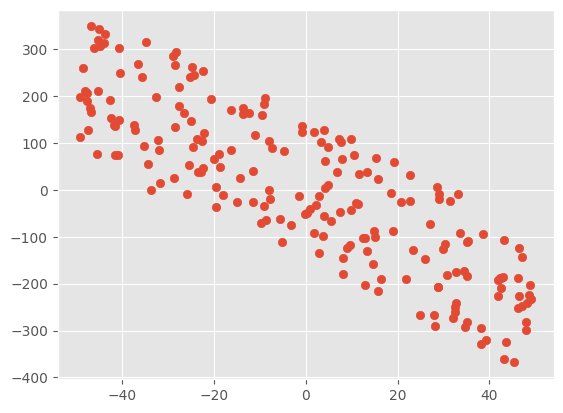

In [4]:
plt.scatter(X[:,1],T)

In [5]:
def log_norm(x, mu, std):
    """Compute the log pdf of x,
    under a normal distribution with mean mu and standard deviation std."""
    
    return -0.5 * torch.log(2*np.pi*std**2) - (0.5 * (1/(std**2))* (x-mu)**2)

In [6]:
class MCElbo(torch.nn.Module):
    def __init__(self,
                 in_features,
                 out_features):
        super(MCElbo, self).__init__()
        self.n_latent = 100 # Number of latent samples
        self.softplus = torch.nn.Softplus()
        self.in_features = in_features
        self.out_features = out_features
        
        #The parameters we adjust during training.
        self.qm = torch.nn.Parameter(torch.randn(in_features,out_features), requires_grad=True)
        self.qs= torch.nn.Parameter(torch.randn(in_features,out_features), requires_grad=True)
        
        #create holders for prior mean and std, and likelihood std.
        self.prior_m = Variable(torch.randn(in_features,out_features), requires_grad=False)
        self.prior_s = Variable(torch.randn(in_features,out_features), requires_grad=False)
        self.likelihood_s = Variable(torch.FloatTensor((1)), requires_grad=False)
        
        #Set the prior and likelihood moments.
        self.prior_s.data.fill_(1.0)
        self.prior_m.data.fill_(0.9)
        self.likelihood_s.data.fill_(5.5)
     
        
    def generate_rand(self):
        return np.random.normal(size=(self.n_latent,self.in_features,self.out_features))
    
    def reparam(self, eps):
        eps = Variable(torch.FloatTensor(eps))
        return  (eps*self.softplus(self.qs)).add(self.qm)
    
    def compute_elbo(self, x, t):
        eps = self.generate_rand()
        z = self.reparam(eps)

        q_likelihood = log_norm(z, self.qm, self.softplus(self.qs))
        q_likelihood = torch.mean(q_likelihood)

        prior = log_norm(z, self.prior_m, self.prior_s)
        prior = torch.mean(prior)

        preds = torch.einsum("ij,kjl->kil",x,z)
        likelihood = torch.mean(torch.sum(log_norm(t, preds, self.likelihood_s), 0))
        
        kld_mc = q_likelihood - prior
        loss = likelihood - kld_mc
        return loss

In [7]:
x = torch.randn(10,2)
z = torch.randn(5,2,1)
res = torch.einsum("ij,kjl->kil",x,z)

for k in range(z.size(0)):
    for i in range(x.size(0)):
        res_man = x[i] @ z[k]
        assert torch.allclose(res[k,i],res_man)



In [8]:
c = MCElbo(2,1)
optimizer = torch.optim.Adam(c.parameters(),lr=0.2)
x = Variable(torch.Tensor(X), requires_grad=False) 
t = Variable(torch.Tensor(T), requires_grad=False)

for i in range(3000):
    loss = -c.compute_elbo(x, t)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    if i % 250 ==0:
        print(c.qm.data.numpy(), (c.softplus(c.qs).data**2).numpy())

[[-0.29815114]
 [-0.46846476]] [[0.40923828]
 [2.2955444 ]]
[[ 3.1749861]
 [-5.0013385]] [[0.00050855]
 [0.0014779 ]]
[[ 3.1774511]
 [-5.0020585]] [[0.0002753 ]
 [0.00067901]]
[[ 3.1770062]
 [-4.998566 ]] [[0.00021548]
 [0.00042164]]
[[ 3.175474 ]
 [-4.9999475]] [[0.00019709]
 [0.00030678]]
[[ 3.1758325]
 [-4.9977217]] [[0.00018744]
 [0.00024901]]
[[ 3.1776457]
 [-4.9990253]] [[0.00018667]
 [0.00021587]]
[[ 3.1768994]
 [-4.999301 ]] [[0.00018589]
 [0.00019816]]
[[ 3.1781442]
 [-4.9995675]] [[0.00018651]
 [0.00018686]]
[[ 3.1774547]
 [-4.99984  ]] [[0.0001887 ]
 [0.00018011]]
[[ 3.1795518]
 [-4.9982753]] [[0.00018441]
 [0.00017653]]
[[ 3.1799817]
 [-4.9989705]] [[0.0001918]
 [0.0001751]]


In [9]:
analytical_posterior_var = ((1/5.5**2)*X.T@ X +1)**-1
analytical_posterior_var, c.softplus(c.qs).data.numpy()**2

(array([[0.00018726, 0.0059363 ],
        [0.0059363 , 0.00017388]]),
 array([[0.00018678],
        [0.00017632]], dtype=float32))

In [10]:
X.T @ T

array([[ 487765.3550612],
       [-853682.9332355]])

In [11]:
analytical_posterior_mean = analytical_posterior_var@(0.9+((1/5.5**2)*X.T @ T))
analytical_posterior_mean, c.qm.data.numpy()

(array([[-164.50278816],
        [  90.8181156 ]]),
 array([[ 3.1733289],
        [-4.9999022]], dtype=float32))

In [12]:
analytical_posterior_mean.shape

(2, 1)

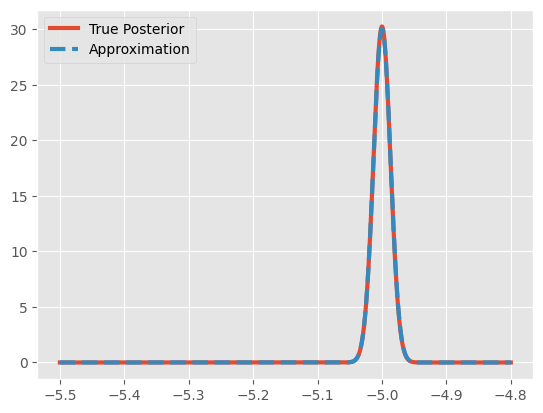

In [13]:
from scipy.stats import norm
param_in, param_out = 1,0
xn = np.arange(-5.5, -4.8, 0.0001)
true_dist = norm(loc = -5, 
                 scale =(analytical_posterior_var[param_in, param_in])**0.5)
q_dist = norm(loc = c.qm[param_in, param_out].data.numpy(), scale = c.softplus(c.qs[param_in, param_out]).data.numpy())
yn = true_dist.pdf(xn).ravel()
plt.plot(xn, yn, linewidth=3, label="True Posterior")
plt.plot(xn, q_dist.pdf(xn).ravel(), '--', linewidth=3,
         label="Approximation")
plt.legend()

In [14]:
yn

array([1.86592938e-311, 2.48752052e-311, 3.31598963e-311, ...,
       4.23702357e-049, 3.77698068e-049, 3.36669418e-049])